In [54]:
import xarray as xr, cartopy, numpy as np, regionmask, pandas as pd, geopandas as gpd
from datetime import datetime, timedelta
import glob, re

import matplotlib, matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
matplotlib.rcParams['savefig.bbox'] = "tight"    # always save with tight bounding box
matplotlib.rcParams["savefig.facecolor"] = "w"   # always save with white (rather than transparent) background

import warnings; warnings.filterwarnings("ignore", category = FutureWarning)

fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/IB_fire"
mapproj = cartopy.crs.PlateCarree()

sf = gpd.read_file(fpath+"/sf_nw-iberia")

# asymmetric divergent colourbar
class MidpointNormalise(matplotlib.colors.Normalize):
    """ From: https://matplotlib.org/users/colormapnorms.html"""
    def __init__(self, vmin=None, vmax=None, midpoint=0, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...

        result, is_scalar = self.process_value(value)
        self.autoscale_None(result)

        vlargest = max( abs( self.vmax - self.midpoint ), abs( self.vmin - self.midpoint ) )
        x, y = [ self.midpoint - vlargest, self.midpoint, self.midpoint + vlargest], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

# Compare dkrz data with ClimExp

DKRZ data was bilinearly interpolated from native N48 grid - check if this gives same result as the builtin pre-processing

In [59]:
# precip
# very symmetric errors so almost certainly the times are offset in some way
cx = xr.open_dataset(fpath+"/tp_era5_1950-2025.nc").tp.sel(time = slice(None, "2024"))
dkrz = xr.open_dataset(fpath+"/tp_era5-regridded_1950-2024.nc").tp.rename(latitude = "lat", longitude = "lon")

In [65]:
# tasmax
cx = xr.open_dataset(fpath+"/tmax_era5_1950-2025.nc").tmax.sel(time = slice(None, "2024"))
dkrz = xr.open_dataset(fpath+"/tmax_era5-regridded_1950-2024.nc").tmax.rename(latitude = "lat", longitude = "lon")

In [66]:
rm = regionmask.defined_regions.natural_earth_v5_1_2.countries_50.mask(cx)

In [67]:
cx_e = cx.where(rm == 54, drop = True).mean(["lat", "lon"])
dkrz_e = dkrz.where(rm == 54, drop = True).mean(["lat", "lon"])

In [68]:
cx_p = cx.where(rm == 78, drop = True).mean(["lat", "lon"])
dkrz_p = dkrz.where(rm == 78, drop = True).mean(["lat", "lon"])

In [69]:
diff_e = cx_e - dkrz_e
diff_p = cx_p - dkrz_p

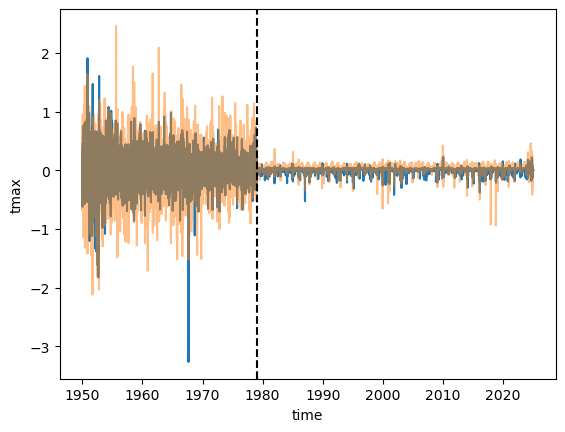

In [70]:
diff_e.plot()
diff_p.plot(alpha = 0.5)
plt.axvline(datetime(1979,1,1), color = "k", ls = "--")

# 2025 vs previous years

In [230]:
df = pd.read_csv(fpath+"/ts-daily_era5_allvars.csv", index_col = "time", parse_dates = ["time"])
df["tp_cumsum"] = df[["tp"]].groupby(df.index.year).cumsum()
df["cumdsr"] = df[["dsr"]].groupby(df.index.year).cumsum()

In [231]:
days = pd.date_range(start = "2020-01-01", end = "2021-01-01")
labelticks = [i+1 for i in range(len(days)) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(len(days)) if (days[i].day) == 15]

In [253]:
# lastday = df.loc["2025", ["fwi"]].rolling(5).mean().idxmax().dt.dayofyear
# lastday = lastday.values[0] - 5
lastday = 228

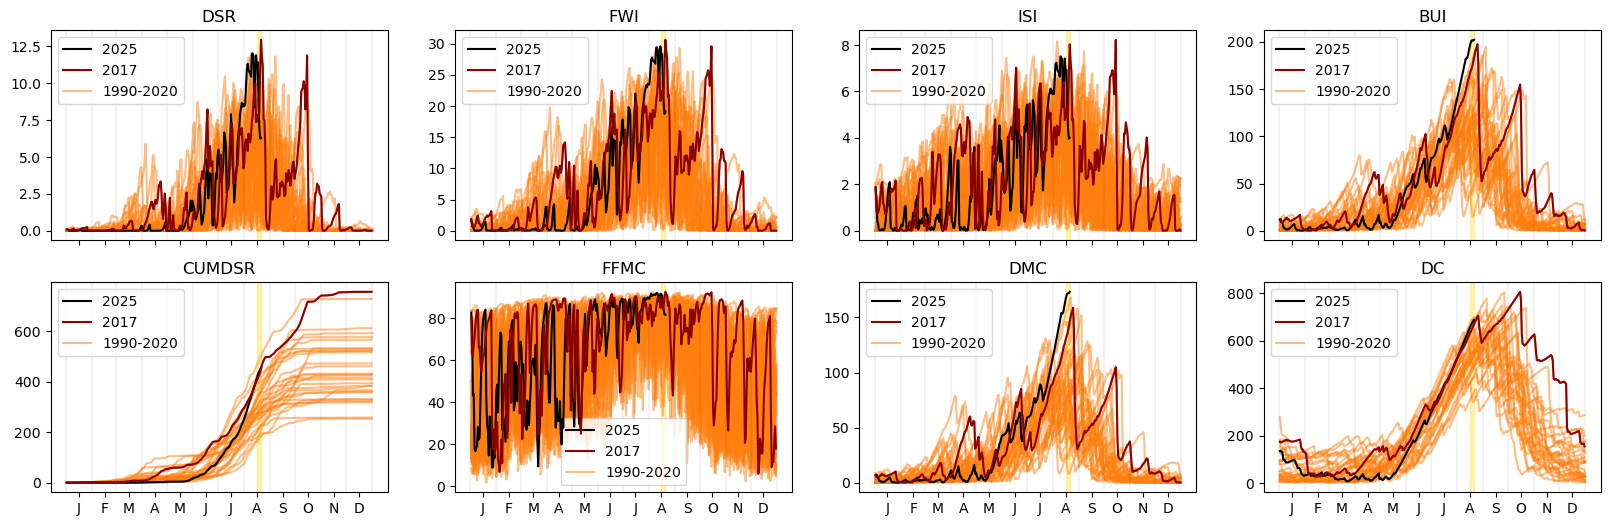

In [259]:
ystart = 1990; yend = 2020
vartype = "fwi"

var_list = {"meteo" : ["tmax", "hursmin", "sfcWindmax", "tp", "dasmax", "vpd", "hdwi", "tp_cumsum"],
            "fwi" : ['dsr', 'fwi', 'isi', 'bui', "cumdsr", 'ffmc', 'dmc', 'dc']}[vartype]

nc = 4; nvar = len(var_list); nr = int(np.ceil(nvar / nc))
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*5, nr*3), dpi = 100, sharex = True, sharey = False)
for i in range(nvar):
    ax = axs.flatten()[i]
    varnm = var_list[i]

    ts = df[[varnm]]
    y = 2025; ts_y = ts.loc[str(y)]; ax.plot(ts_y.index.dayofyear, ts_y, color = "k", label = "2025", zorder = 99)
    y = 2017; ts_y = ts.loc[str(y)]; ax.plot(ts_y.index.dayofyear, ts_y, color = "darkred", label = "2017", zorder = 99)
    for y in range(ystart,yend):
        ts_y = ts.loc[str(y)]
        ax.plot(ts_y.index.dayofyear, ts_y, color = "tab:orange", alpha = 0.5, label = "_years")
    
    ax.set_title(varnm.upper())

    ax.legend(["2025", "2017", str(ystart)+"-"+str(yend)])
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(len(days)) if (days[x].day) == 1]

    ylim = ax.get_ylim()
    ax.add_patch(Rectangle((lastday, ylim[0]-5), 5, ylim[1]-ylim[0]+10, color = "gold", alpha = 0.3))
    ax.set_ylim(ylim)

for i in range(nvar, nc*nr): axs.flatten()[i].set_axis_off()

plt.savefig("fig/annual-climatology_"+vartype+"-vars.png")

## Accumulations

In [255]:
ystart = 1990; yend = 2020

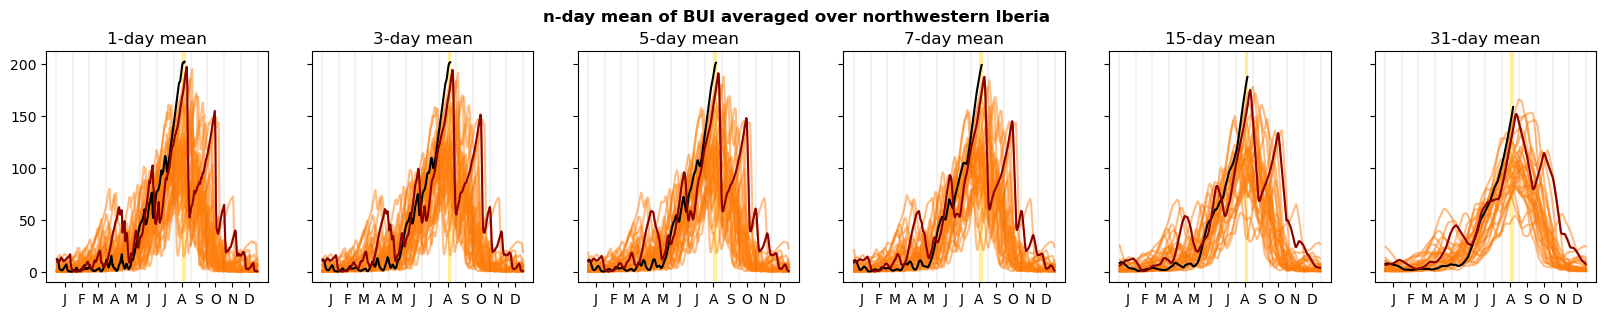

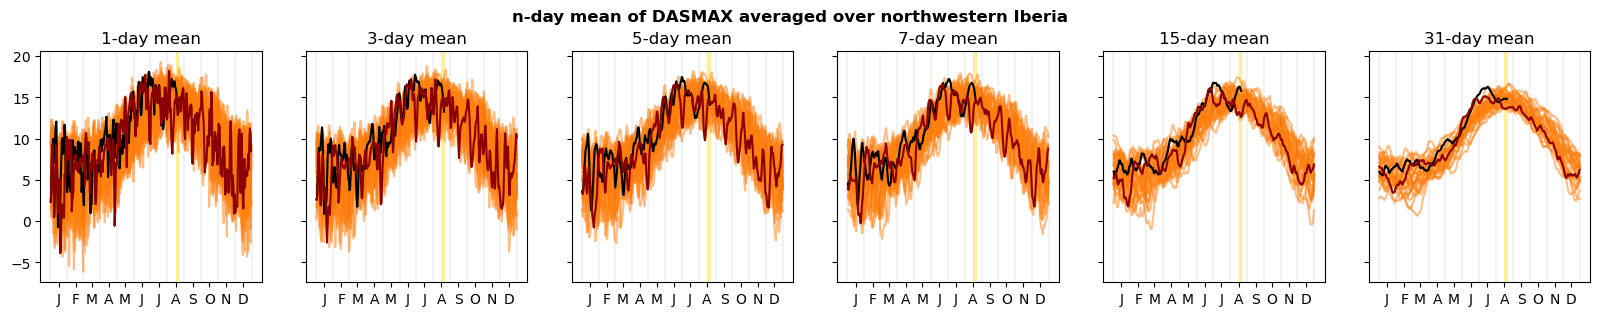

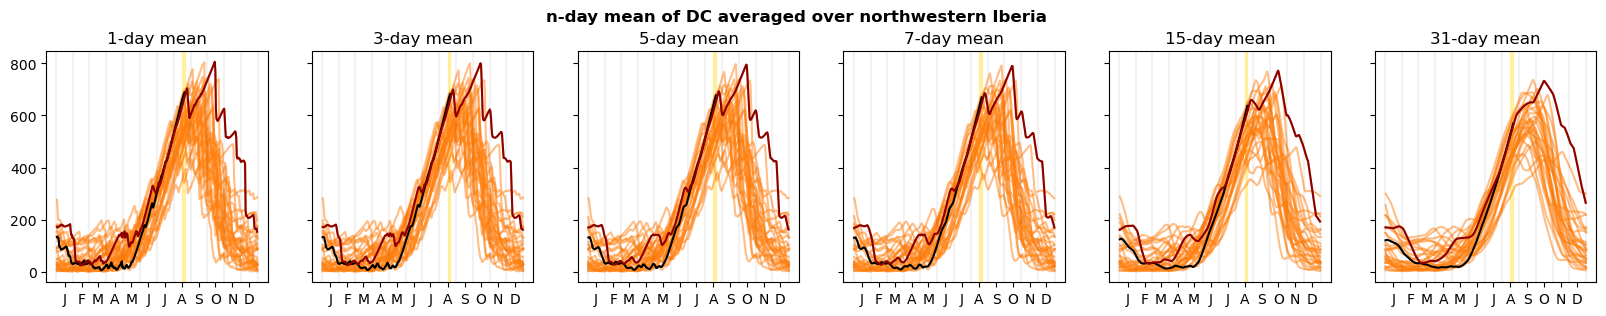

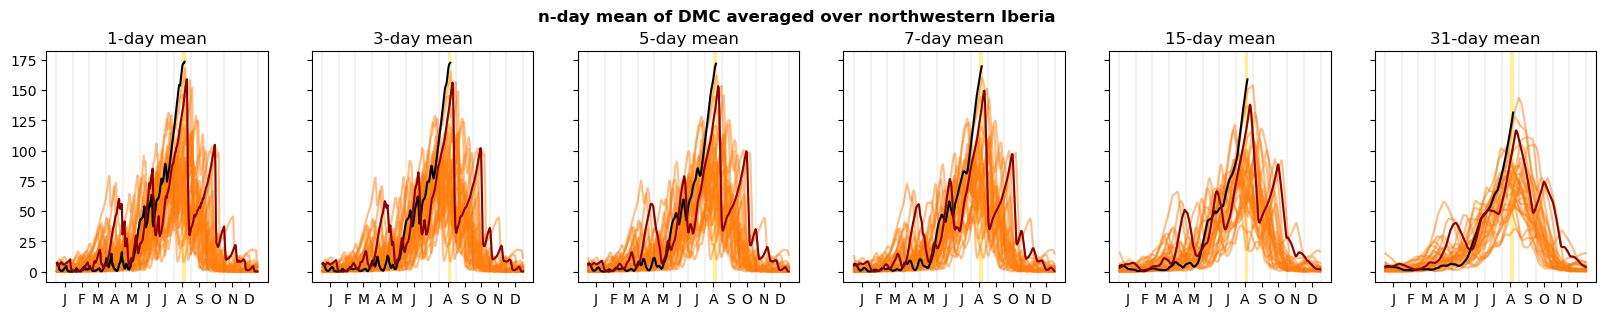

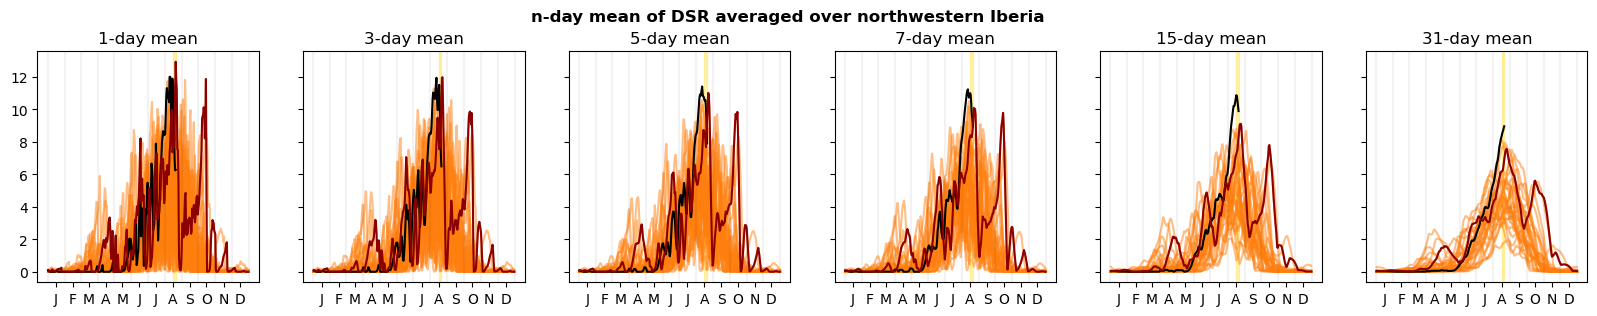

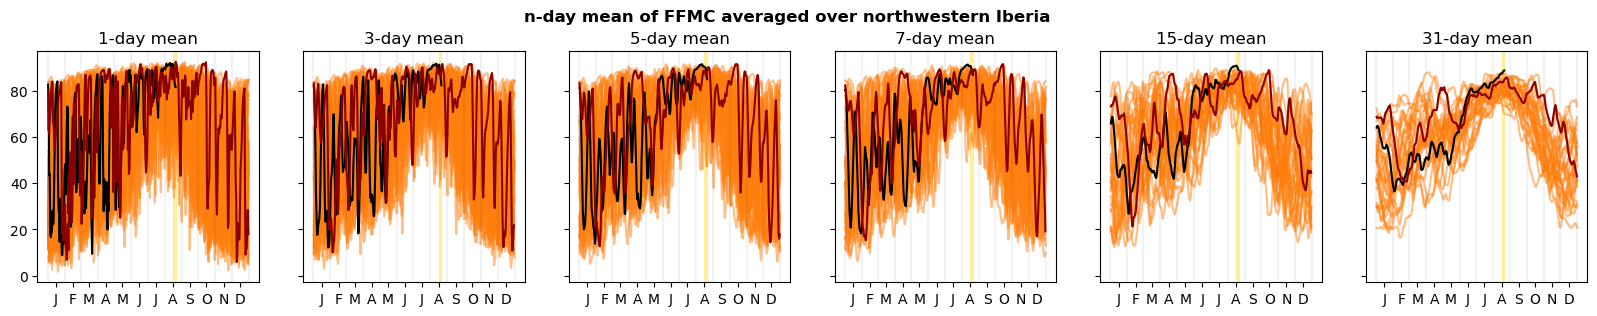

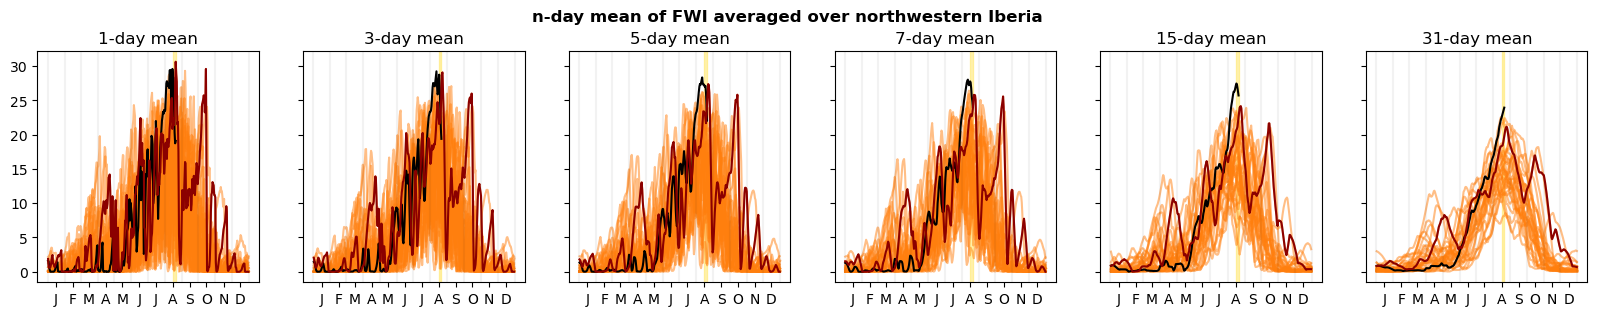

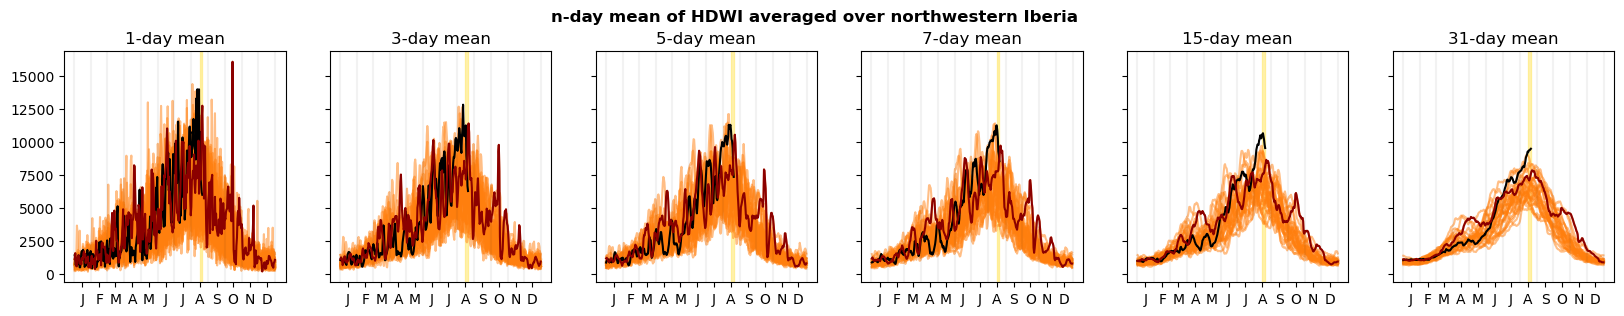

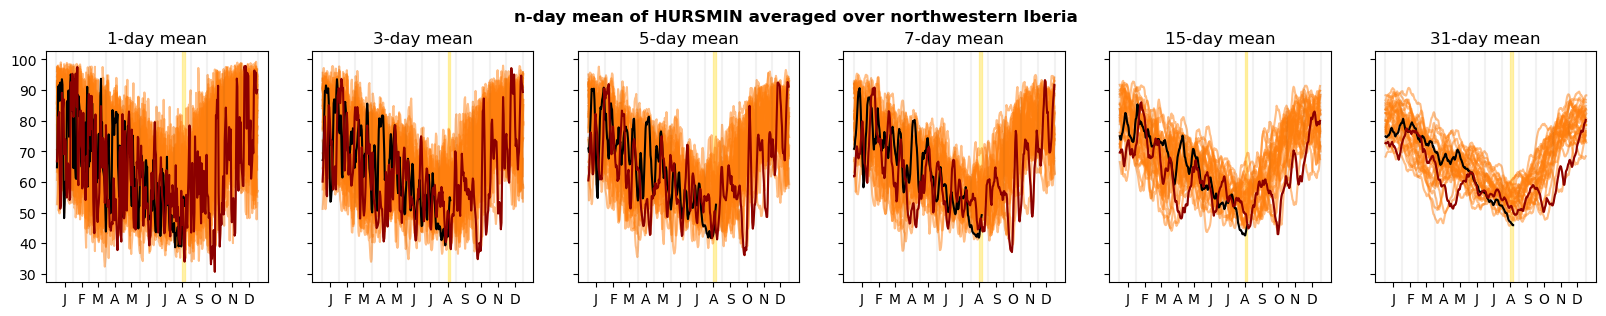

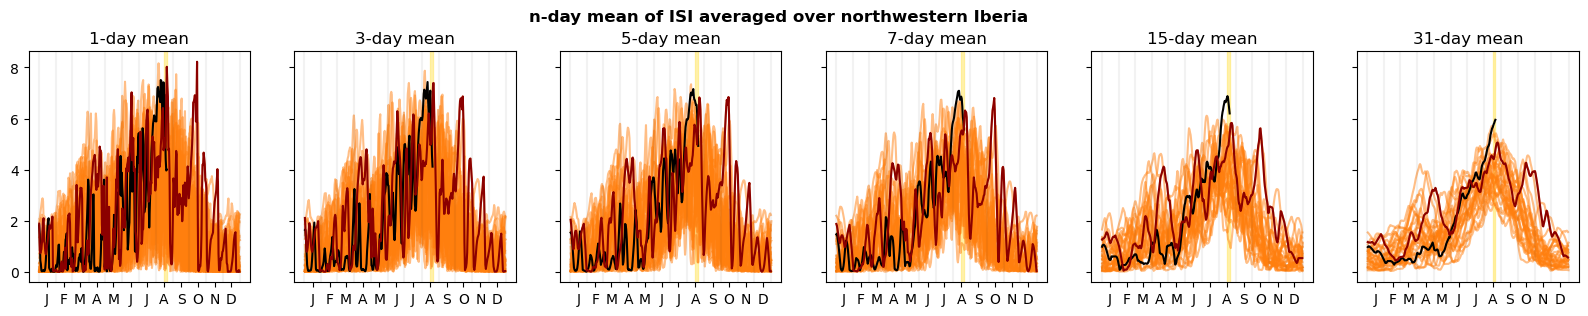

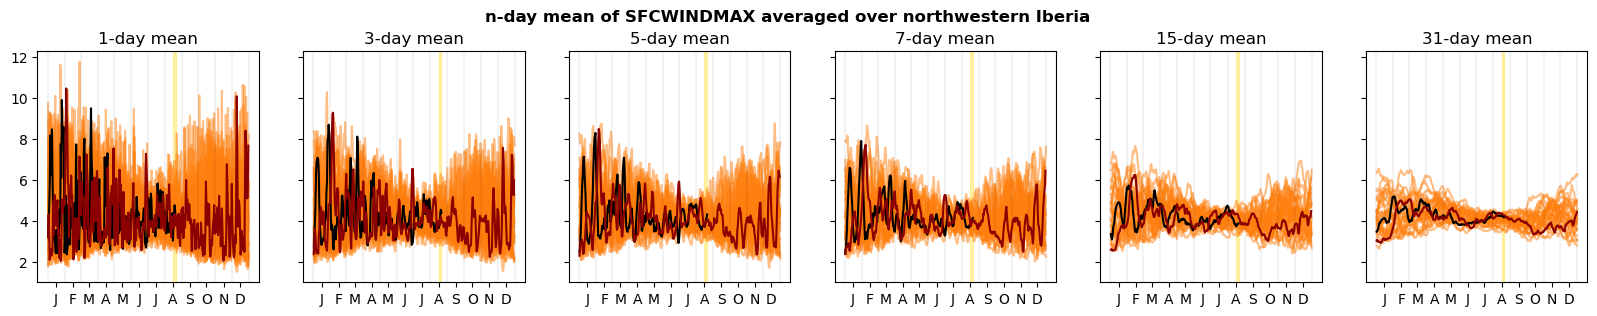

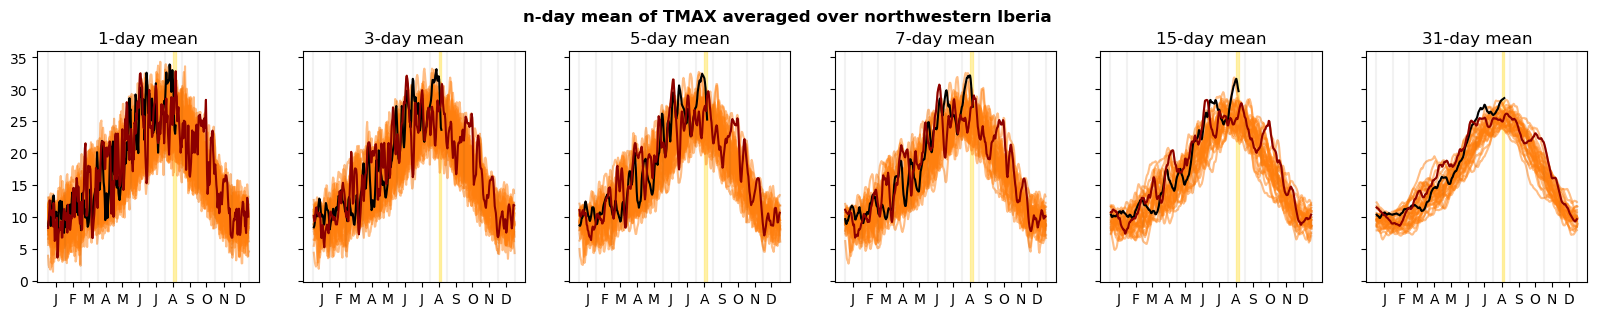

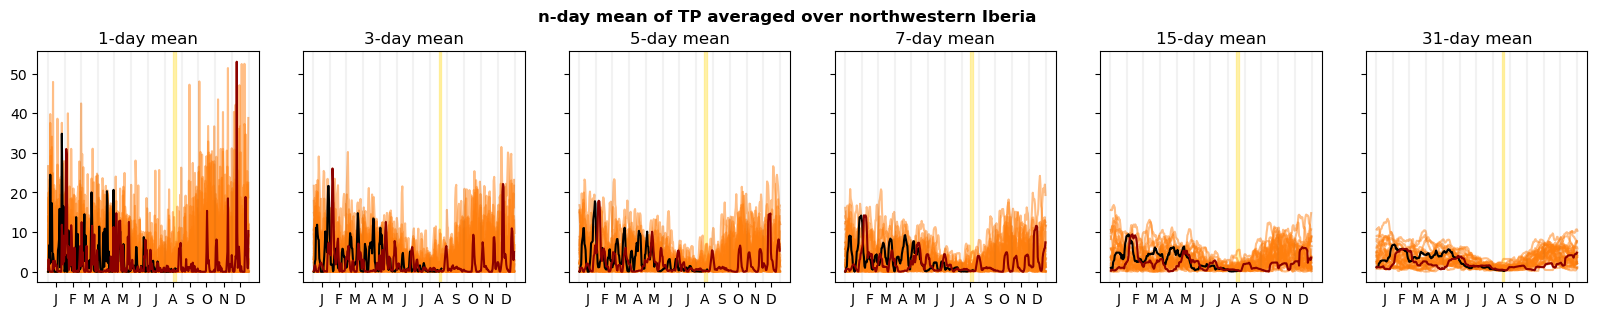

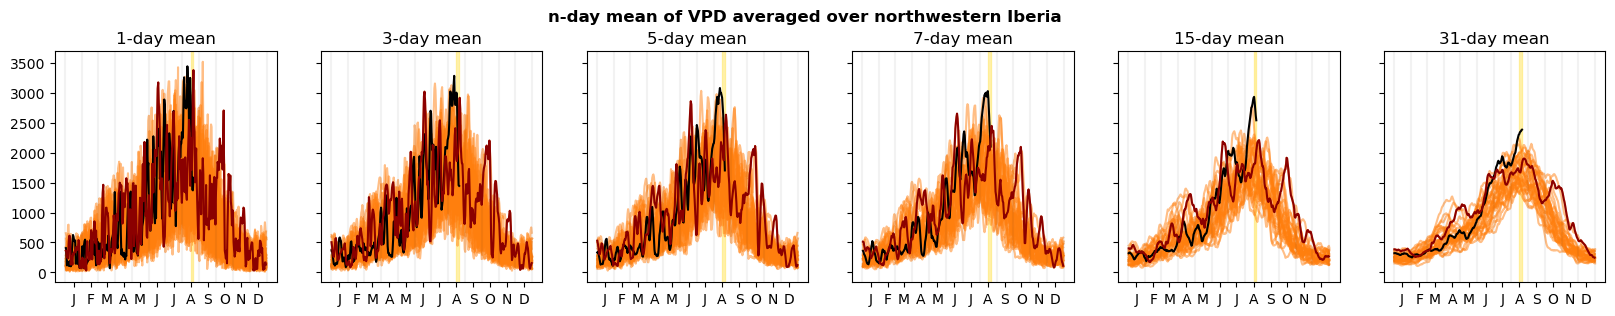

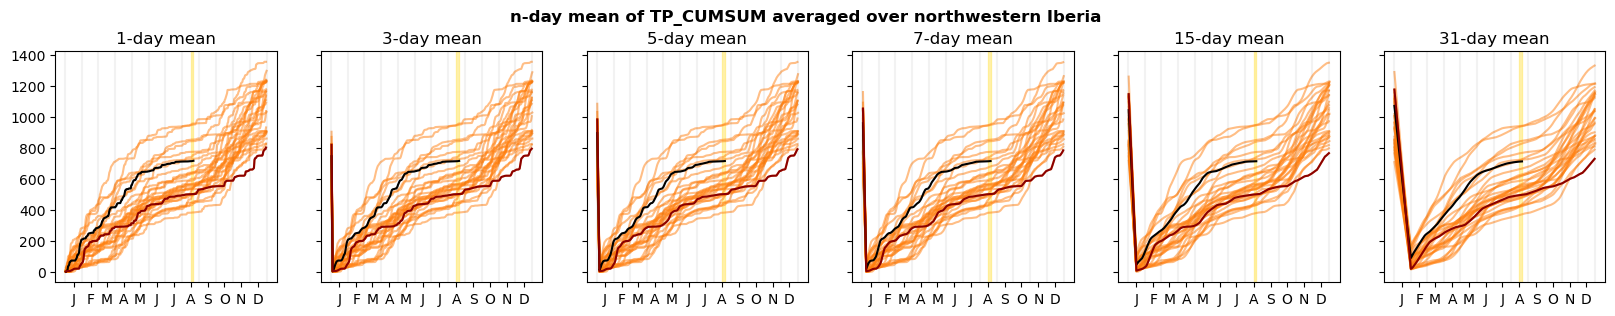

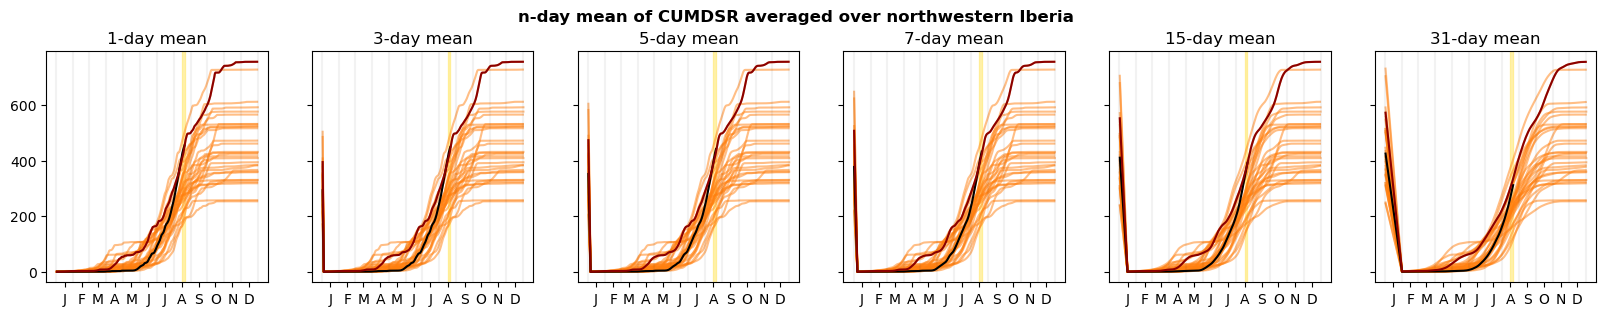

In [256]:
for varnm in df.columns:
    ndays = [1,3,5,7,15,31]
    
    fig, axs = plt.subplots(ncols = len(ndays), nrows = 1, figsize = (nc*5, 3), dpi = 100, sharex = True, sharey = True)
    
    for i in range(len(ndays)):
        ax = axs[i]
        ts = df[[varnm]].rolling(ndays[i]).mean()
    
        y = 2025; ts_y = ts.loc[str(y)]; ax.plot(ts_y.index.dayofyear, ts_y, color = "k", label = "2025", zorder = 99)
        y = 2017; ts_y = ts.loc[str(y)]; ax.plot(ts_y.index.dayofyear, ts_y, color = "darkred", label = "2017", zorder = 99)
        for y in range(ystart,yend):
            ts_y = ts.loc[str(y)]
            ax.plot(ts_y.index.dayofyear, ts_y, color = "tab:orange", alpha = 0.5, label = "_years")
    
        # ax.legend(["2025", "2017", str(ystart)+"-"+str(yend)])
        ax.set_xticks(labelticks)
        ax.set_xticklabels(labels)
        [ax.axvline(x, color = "k", alpha = 0.05) for x in range(len(days)) if (days[x].day) == 1] 

        ylim = ax.get_ylim()
        ax.add_patch(Rectangle((lastday, ylim[0]-10), 5, ylim[1]-ylim[0]+10, color = "gold", alpha = 0.3))
        ax.set_ylim(ylim)
    
        ax.set_title(str(ndays[i])+"-day mean")
    
    plt.suptitle("n-day mean of "+varnm.upper()+" averaged over northwestern Iberia", fontweight = "bold", y = 1.02)
    
    plt.savefig("fig/n-day_"+varnm+".png")

# Pointwise trend fitting

## Quick gridded trend (OLS regression)

In [ ]:
for varnm in ["t2m-jja", "tmax-jja", "tp-jja", "dsr5x"]:

    # load pre-computed index
    da = xr.open_dataset("data/"+varnm+"_era5_1950-2025.nc")[varnm.split("-")[0]]
    
    # load gmst & trim to fit
    gmst = pd.read_table("gmst.txt", comment = "#", sep = " +", header = None, names = ["year", "gmst"], index_col = "year", engine = "python").to_xarray().gmst
    gmst = gmst.sel(year = gmst.year.isin(da.year))
    
    fitted_coeffs = da.assign_coords(year = gmst.values).polyfit("year", deg = 1).polyfit_coefficients
    fitted_coeffs.to_netcdf("ols-fit_"+varnm+".nc")

In [22]:
da = np.log(xr.open_dataset("data/tp-jja_era5_1950-2025.nc").tp)

gmst = pd.read_table("gmst.txt", comment = "#", sep = " +", header = None, names = ["year", "gmst"], index_col = "year", engine = "python").to_xarray().gmst
gmst = gmst.sel(year = gmst.year.isin(da.year))
    
fitted_coeffs = da.assign_coords(year = gmst.values).polyfit("year", deg = 1).polyfit_coefficients
fitted_coeffs.to_netcdf("ols-fit_logtp-jja.nc")

In [12]:
fitted = {varnm : xr.open_dataset("ols-fit_"+varnm+"_era5_1950-2025.nc") for varnm in ["t2m-jja", "tmax-jja", "tp-jja", "dsr5x"]}

/rds/general/user/cb2714/home/miniforge3/envs/wwa/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/rds/general/user/cb2714/home/miniforge3/envs/wwa/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/rds/general/user/cb2714/home/miniforge3/envs/wwa/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/rds/general/user/cb2714/home/miniforge3/envs/wwa/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no 

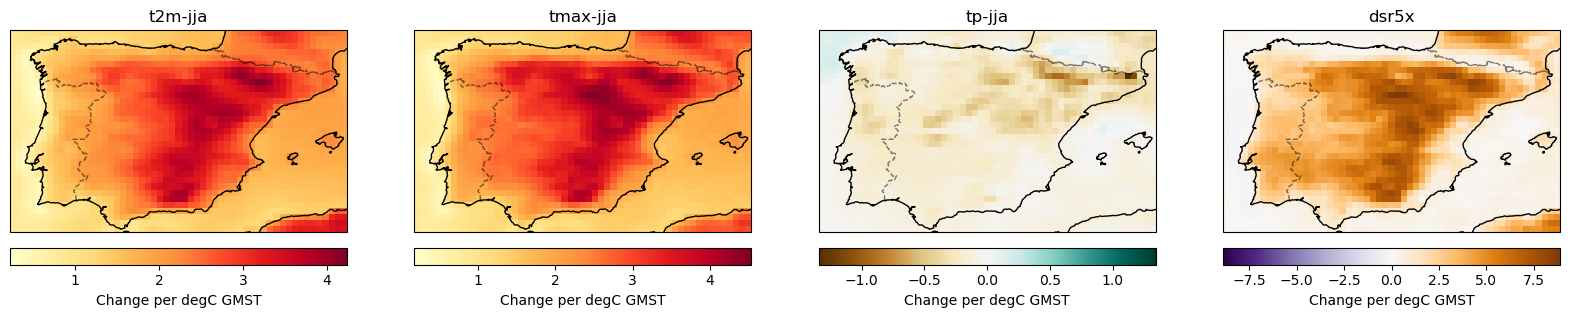

In [31]:
fig, axs = plt.subplots(ncols = 4, figsize = (4*5, 4), subplot_kw = {"projection" : mapproj})

for i in range(4):
    ax = axs[i]
    varnm = list(fitted.keys())[i]
    cmap = ["YlOrRd", "YlOrRd", "BrBG", "PuOr_r"][i]

    fitted[varnm]["polyfit_coefficients"].sel(degree = 1).plot(ax = ax, cmap = cmap, cbar_kwargs = {"location" : "bottom", "label" : "Change per degC GMST", "pad" : 0.05})
    ax.set_title(varnm)
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--", alpha = 0.5)

plt.savefig("fig/ols-fitted-trends.png")

## Nonstationary distributions

### Reconstruct maps

In [5]:
def vec2map(x, mask):
    
    # reconstruct vector into map
    # create an empty map with NA in same cells as masks
    arr = mask.where(np.isnan(mask), 0)
    
    # get coordinates of non-empty cells
    px = np.argwhere(~np.isnan(mask.values))
    
    # Transfer vector values into non-empty cells in array
    if len(px) == len(x):
        for i in list(range(len(px))): arr[px[i,0], px[i,1]] = x[i]
        return arr
    else:
        print(str(len(x))+" values, but "+str(len(px))+" cells")
        return
        
        

In [6]:
for fnm in glob.glob("pointwise/*res*.csv"):
    
    varnm = re.sub("-flattened.+","",fnm).split("/")[-1]
    df = pd.read_csv(fnm, index_col = 0)
    df = df.loc[np.isnan(df).sum(axis = 1) < 10]
    tmplt = xr.open_dataset("pointwise/map-tmplt_"+varnm+"_era5.nc")[re.sub("log","",varnm).split("-")[0]]

    # reconstruct maps
    res = xr.merge([vec2map(df.loc[r], tmplt).rename(r) for r in df.index])
    
    # replace infinite values with very high value
    res["PR"] = res.PR.where(np.isfinite(res.PR), 100).where(~np.isnan(res.PR))

    res.to_netcdf("ns-fit_"+varnm+"_"+fnm.split("-")[-1].split("_")[0]+".nc")

### Maps of pointwise trends

In [32]:
# load all the fitted trends
ns_fit = {fnm[7:-3].split("_")[0] : xr.open_dataset(fnm) for fnm in glob.glob("ns-fit*.nc")}
ols_fit = {fnm[8:-3] : xr.open_dataset(fnm) for fnm in glob.glob("ols-fit*.nc")}

var_list = ['dsr5x', 'tmax-jja', 't2m-jja', 'tp-jja', 'logtp-jja']

## Compare NS fit with OLS

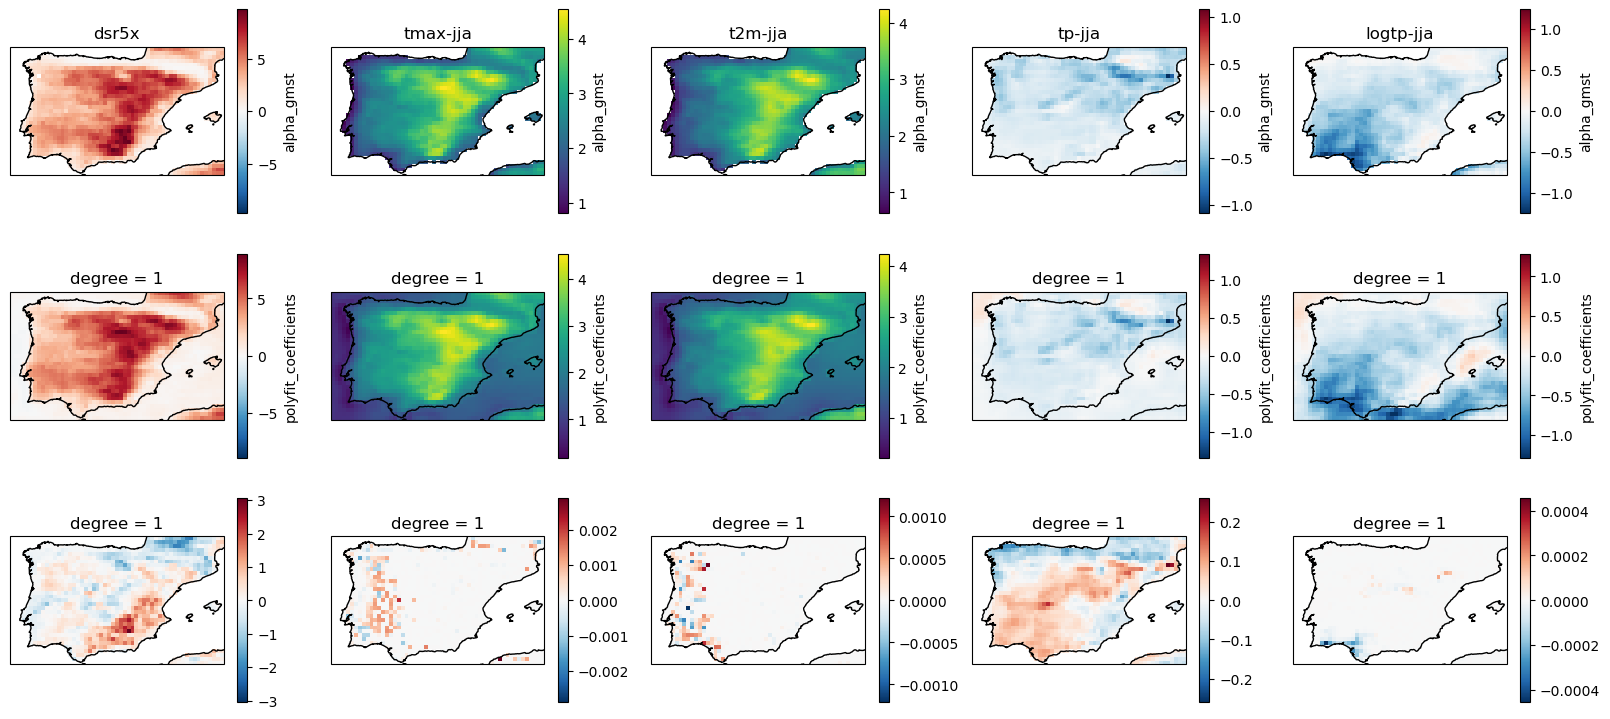

In [39]:
nc = len(var_list); nr = 3

fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*4, nr*3), dpi = 100, subplot_kw = {"projection" : mapproj})

for i in range(nc):
    varnm = var_list[i]

    ns_fit[varnm].alpha_gmst.plot(ax = axs[0,i])
    ols_fit[varnm].polyfit_coefficients.sel(degree =  1).plot(ax = axs[1,i])

    (ns_fit[varnm].alpha_gmst - ols_fit[varnm].polyfit_coefficients.sel(degree =  1)).plot(ax = axs[2,i])

    axs[0,i].set_title(varnm)

for ax in axs.flatten(): ax.coastlines()

## Maps of changes

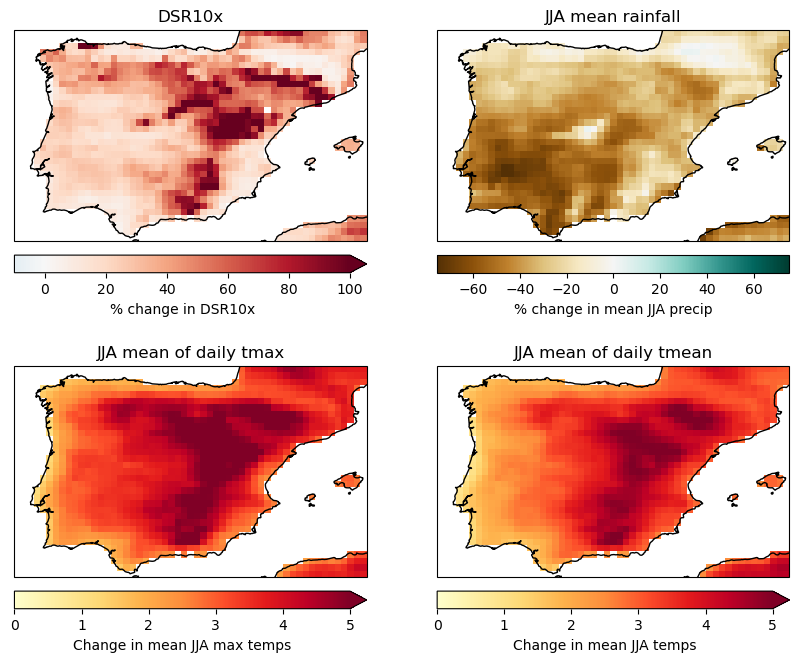

In [7]:
var_list = ['dsr10x', 'tmax-jja', 't2m-jja', 'tp-jja']
ns_fit = {varnm: xr.open_mfdataset("ns-fit_"+varnm+"*.nc") for varnm in var_list}

nc = 2; nr = 2

cbar_kwargs = {"location" : "bottom", "pad" : 0.05}

fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*5, nr*4), dpi = 100, subplot_kw = {"projection" : mapproj})

ns_fit["dsr10x"].dI_rel.plot(ax = axs[0,0], norm = MidpointNormalise(midpoint = 0, vmax = 100, vmin = -10), cmap = "RdBu_r", cbar_kwargs = cbar_kwargs | {"label" : "% change in DSR10x"})
axs[0,0].set_title("DSR10x")

ns_fit["tp-jja"].dI_rel.plot(ax = axs[0,1], cmap = "BrBG", cbar_kwargs = cbar_kwargs | {"label" : "% change in mean JJA precip"})
axs[0,1].set_title("JJA mean rainfall")

ns_fit["tmax-jja"].dI_abs.plot(ax = axs[1,0],cmap = "YlOrRd", vmin = 0, vmax = 5, cbar_kwargs = cbar_kwargs | {"label" : "Change in mean JJA max temps"})
axs[1,0].set_title("JJA mean of daily tmax")

ns_fit["t2m-jja"].dI_abs.plot(ax = axs[1,1],cmap = "YlOrRd", vmin = 0, vmax = 5, cbar_kwargs = cbar_kwargs | {"label" : "Change in mean JJA temps"})
axs[1,1].set_title("JJA mean of daily tmean")

for ax in axs.flatten():
    ax.coastlines()


## dsr10x vs dsr5x

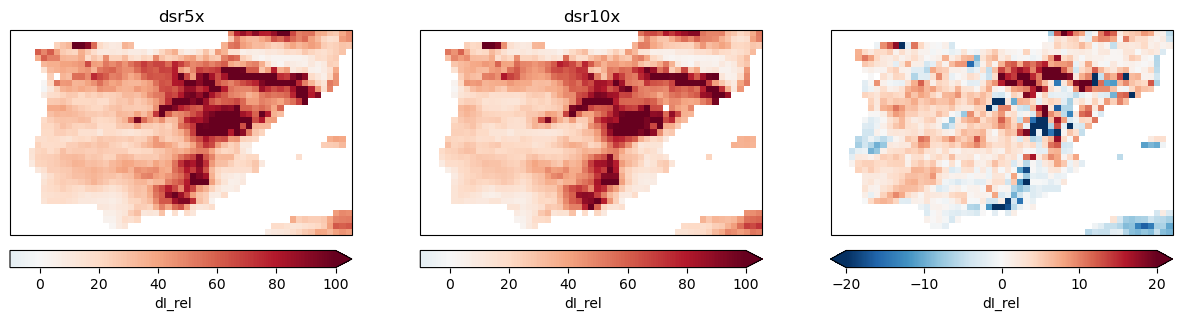

In [19]:
dsr5x = xr.open_dataset("ns-fit_dsr5x_gev.nc")
dsr10x = xr.open_dataset("ns-fit_dsr10x_gev.nc")

nc = 3; nr = 1
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*5, nr*4), dpi = 100, subplot_kw = {"projection" : mapproj})

dsr5x.dI_rel.plot(ax = axs[0], cbar_kwargs = cbar_kwargs, norm = MidpointNormalise(midpoint = 0, vmax = 100, vmin = -10), cmap = "RdBu_r")
axs[0].set_title("dsr5x")

dsr10x.dI_rel.plot(ax = axs[1], cbar_kwargs = cbar_kwargs, norm = MidpointNormalise(midpoint = 0, vmax = 100, vmin = -10), cmap = "RdBu_r")
axs[1].set_title("dsr10x")

(dsr5x.dI_rel - dsr10x.dI_rel).plot(ax = axs[2], cbar_kwargs = cbar_kwargs, vmin = -20, vmax = 20, cmap = "RdBu_r")


## tmax vs tmean

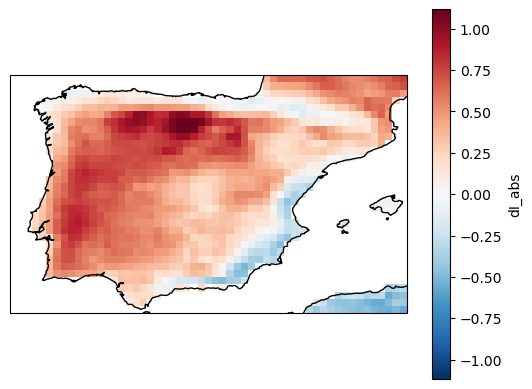

In [ ]:
(ns_fit["tmax-jja"].dI_abs - ns_fit["t2m-jja"].dI_abs).plot(subplot_kws = {"projection" : mapproj})
plt.gca().coastlines()

# Spring precip

In [44]:
from statsmodels.nonparametric.smoothers_lowess import lowess

tp = xr.open_dataset(fpath+"/ts-daily/ts-tp_era5_1950-2025.nc").tp

In [45]:
tp_fma = tp.sel(time = tp.time.dt.month.isin([2,3,4])).resample(time = "AS").mean()
tp_ma = tp.sel(time = tp.time.dt.month.isin([3,4])).resample(time = "AS").mean()

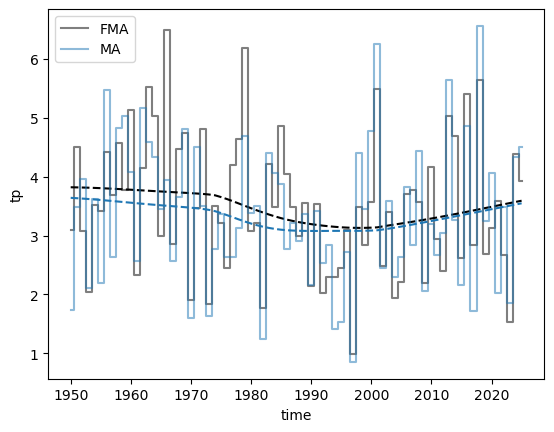

In [46]:
tp_fma.plot(drawstyle = "steps-mid", color = "k", alpha = 0.5, label = "FMA")
plt.plot(tp_fma.time, lowess(tp_fma.values, tp_fma.time.dt.year)[:,1], color = "k", ls = "--")

tp_ma.plot(drawstyle = "steps-mid", color = "tab:blue", alpha = 0.5, label = "MA")
plt.plot(tp_ma.time, lowess(tp_ma.values, tp_ma.time.dt.year)[:,1], color = "tab:blue", ls = "--")

plt.legend()

# Event map - 10-day heatwave

In [18]:
tmax = xr.open_dataset(fpath+"/tmax_era5_1950-2025.nc").tmax

end_date = datetime(2025,8,17)
start_date = end_date - timedelta(days = 9)

hw = tmax.sel(time = slice(start_date, end_date)).mean("time")

clim_aug = tmax.groupby("time.month")[8].sel(time = slice("1990","2020")).mean("time")
clim_jja = tmax.groupby("time.season")["JJA"].sel(time = slice("1990","2020")).mean("time")

anom_aug = hw - clim_aug
anom_jja = hw - clim_jja

/rds/general/user/cb2714/home/miniforge3/envs/wwa/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/rds/general/user/cb2714/home/miniforge3/envs/wwa/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


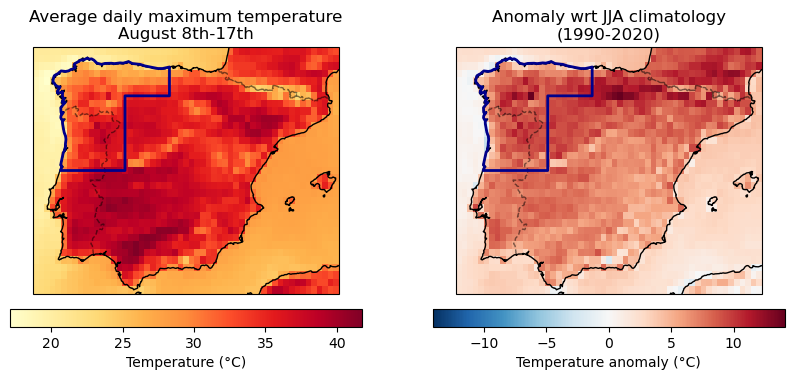

In [56]:
nc = 2; nr = 1
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*5, nr*4), dpi = 100, subplot_kw = {"projection" : mapproj})
cbar_kwargs = {"location" : "bottom", "pad" : 0.05}

ev_tx.plot(ax = axs[0], cbar_kwargs = cbar_kwargs | {"label" : "Temperature (°C)"}, cmap = "YlOrRd")
axs[0].set_title("Average daily maximum temperature\nAugust 8th-17th")

anom_jja.plot(ax = axs[1], cbar_kwargs = cbar_kwargs | {"label" : "Temperature anomaly (°C)"})
axs[1].set_title("Anomaly wrt JJA climatology\n(1990-2020)")

for ax in axs:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--", alpha = 0.5)
    sf.boundary.plot(ax = ax, color = "darkblue", lw = 2)

/rds/general/user/cb2714/home/miniforge3/envs/wwa/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/rds/general/user/cb2714/home/miniforge3/envs/wwa/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


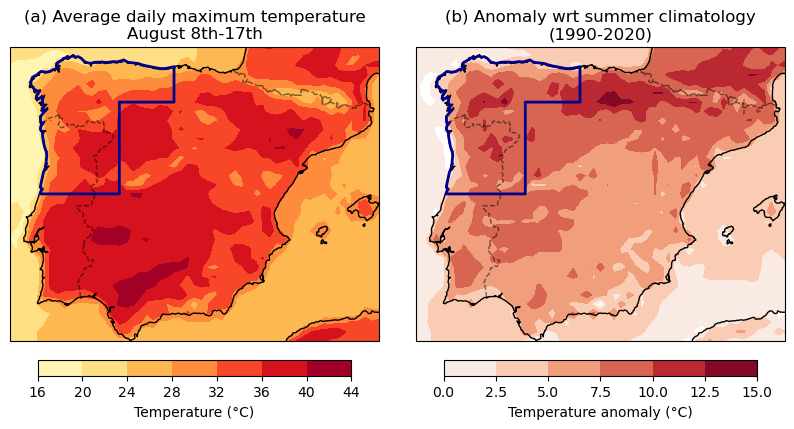

In [70]:
nc = 2; nr = 1
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*5, nr*5), dpi = 100, subplot_kw = {"projection" : mapproj, "extent" : (-10,3.5,36,44)})
plt.subplots_adjust(wspace = 0.1)
cbar_kwargs = {"location" : "bottom", "pad" : 0.05, "shrink" : 0.85}

cbar = axs[0].contourf(ev_tx.lon, ev_tx.lat, ev_tx, cmap = "YlOrRd")
axs[0].set_title("(a) Average daily maximum temperature\nAugust 8th-17th")
plt.colorbar(cbar, ax = axs[0], **cbar_kwargs, label = "Temperature (°C)")

cbar = axs[1].contourf(anom_jja.lon, anom_jja.lat, anom_jja, cmap = "RdBu_r", norm = MidpointNormalise(midpoint = 0, vmax = 15, vmin = -1), levels = np.arange(0,17.5,2.5))
axs[1].set_title("(b) Anomaly wrt summer climatology\n(1990-2020)")
plt.colorbar(cbar, ax = axs[1], **cbar_kwargs, label = "Temperature anomaly (°C)")

for ax in axs:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--", alpha = 0.5)
    sf.boundary.plot(ax = ax, color = "darkblue", lw = 2)